In [1]:
using Random
using Distributions
using Statistics

function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 2.0, #unit profit
    p = 0.50, #probability of delivery
    K = 40, # fixed order cost
    k = 1.0, # variable order cost
    average_demand = 20)
                   
    Xj = S #Stock in the morning
    local Yj::Float64  #  and in the evening.
    profit = 0.0 # Cumulated profit.
    lost_orders = 0
    dimand_dist = Poisson(average_demand)
    stany = Int[]
    for j in 1:m
        Dj = rand(dimand_dist)
        Sj = min(Dj,Xj)
        lost_orders += max(0,Dj-Xj)
        Yj = Xj - Sj
        profit += c*Sj
        profit -= h*Yj
        if Yj <= s && rand() < p
            profit -= K
            profit -= k*(S-Yj)
            Yj = S
        end
        Xj = Yj
        append!(stany, Yj)
    end
    (profit, lost_orders, stany)
end

ArgumentError: ArgumentError: Package Random not found in current path:
- Run `import Pkg; Pkg.add("Random")` to install the Random package.


In [2]:
Random.seed!(0)
res = simulateOneRun(100,50,500)

using PyPlot
plot(1:100, res[3])

UndefVarError: UndefVarError: Random not defined

In [3]:
v = Vector{Float64}(undef,3)

3-element Array{Float64,1}:
 7.9986572e-316
 7.71347855e-316
 7.71347855e-316

In [4]:
function simulateManyRuns(N,m,s,S)
    profits = Vector{Float64}(undef,N)
    lost_os = Vector{Float64}(undef,N)
    for i in 1:N
        res = simulateOneRun(m,s,S)
        profits[i] = res[1]
        lost_os[i] = res[2]
    end
    return (
              profit =(mean(profits),std(profits)),
              lost_orders = (mean(lost_os),std(lost_os))
            )
end

simulateManyRuns (generic function with 1 method)

In [4]:
Random.seed!(0)
simulateManyRuns(100000,40,50,200)


(profit = (292.278995, 69.0504660024719), lost_orders = (20.46071, 30.975746177685732))

In [16]:
# let us check for various values of s and S
Random.seed!(0)
results = Dict{Tuple{Int,Int},NamedTuple}()
for s in 10:40:310, S in (s+10):40:1020
    results[(s,S)] = simulateManyRuns(4000,40,s,S)
end

In [14]:
best_key = (-1,-1)
best_profit = 0.0
for key in keys(results)
    if results[key].profit[1] > best_profit
       best_profit =  results[key].profit[1]
       best_key = key
    end
end
print("Best decision: " ,best_key)
print("Best outcome:", results[best_key])

Best decision: (10, 140)Best outcome:(profit = (765.2900000000001, 94.22975998412966), lost_orders = (262.9, 88.64467145732888))

In [20]:
using PyCall
np = pyimport("numpy")
np.zeros((3,4), dtype="float32")

3×4 Array{Float32,2}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

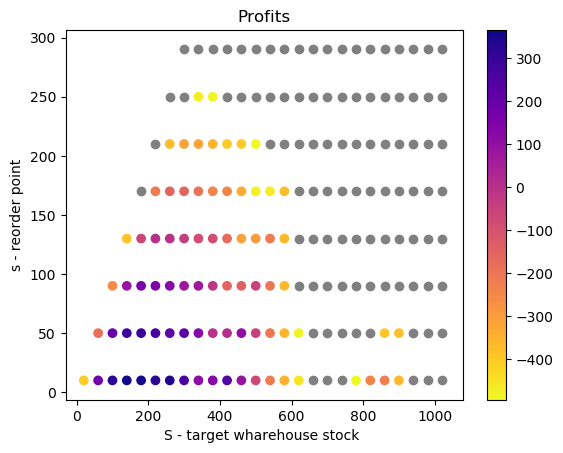

PyObject Text(0.5, 1, 'Profits')

In [22]:
using PyPlot
using PyCall 
cm = pyimport("matplotlib.cm")

vals = [r for r in keys(results) if results[r].profit[1] > -500 ]
vals2 = [r for r in keys(results) if results[r].profit[1] <= -500 ]

scatter([v[2] for v in vals],
        [v[1] for v in vals], 
        c=[results[v].profit[1] for v in vals], 
        cmap=cm.plasma_r )
xlabel("S - target wharehouse stock ")
ylabel("s - reorder point")
colorbar()
scatter([v[2] for v in vals2],
        [v[1] for v in vals2], 
        c="gray")
title("Profits")

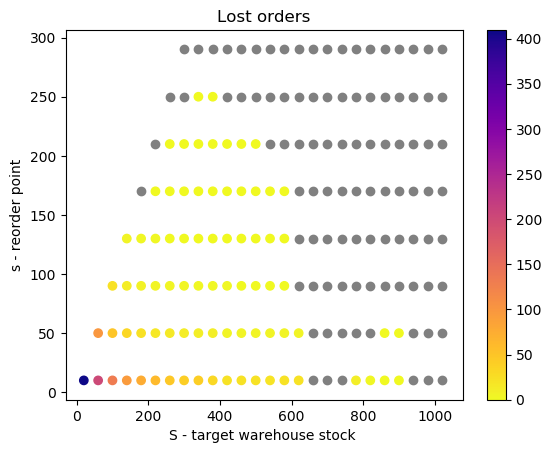

In [29]:
using PyPlot
using PyCall 
cm = PyCall.pyimport("matplotlib.cm")


vals = [r for r in keys(results) if results[r].profit[1] > -500 ]
vals2 = [r for r in keys(results) if results[r].profit[1] <= -500 ]


scatter([v[2] for v in vals],
        [v[1] for v in vals], 
        c=[results[v].lost_orders[1] for v in vals], 
        cmap=cm.plasma_r)
xlabel("S - target warehouse stock ")
ylabel("s - reorder point")
colorbar()
scatter([v[2] for v in vals2],
        [v[1] for v in vals2], 
        c="gray")
title("Lost orders")
savefig(raw"c:\temp\lost_orders.png")

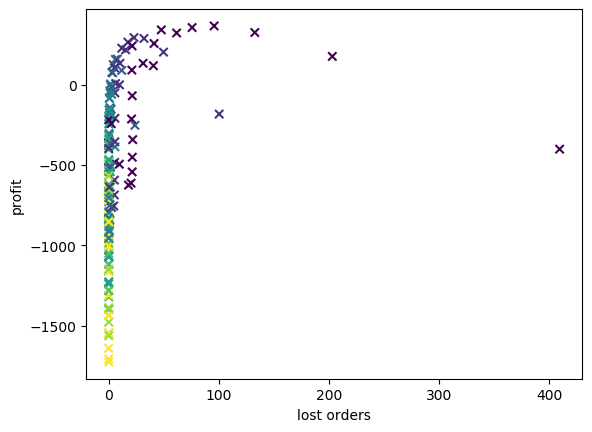

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [30]:
keylist = collect(keys(results))
prs = [results[key].profit[1] for key in keylist]
los = [results[key].lost_orders[1] for key in keylist]
ss = [k[1]*1.0 for k in keylist]

using PyPlot

scatter(los,prs, marker=:x, c=ss)
xlabel("lost orders")
ylabel("profit")
show()